<h3>
Predicting players rating
</h3>

In this project you are going to predict the overall rating of soccer player based on their attributes
such as 'crossing', 'finishing etc.
The dataset you are going to use is from European Soccer Database
(https://www.kaggle.com/hugomathien/soccer) has more than 25,000 matches and more than
10,000 players for European professional soccer seasons from 2008 to 2016.
Download the data in the same folder and run the following commmand to get it in the environment

<h3>
About the Dataset
</h3>

The ultimate Soccer database for data analysis and
machine learning
The dataset comes in the form of an SQL database and contains statistics of about 25,000 football
matches, from the top football league of 11 European Countries. It covers seasons from 2008 to
2016 and contains match statistics (i.e: scores, corners, fouls etc...) as well as the team formations,
with player names and a pair of coordinates to indicate their position on the pitch.
+25,000 matches
+10,000 players
11 European Countries with their lead championship
Seasons 2008 to 2016
Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the
weekly updates
Team line up with squad formation (X, Y coordinates)
Betting odds from up to 10 providers
Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000
matches
The dataset also has a set of about 35 statistics for each player, derived from EA Sports' FIFA video
games. It is not just the stats that come with a new version of the game but also the weekly
updates. So for instance if a player has performed poorly over a period of time and his stats get
impacted in FIFA, you would normally see the same in the dataset.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score
import datetime as dt
import math as math
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
conn = sqlite3.connect('./SoccerData/database.sqlite')
#cursor = conn.cursor()

In [3]:
dfPlayerAttributes = pd.read_sql_query('select * from Player_Attributes', conn)
dfPlayerAttributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [4]:
dfPlayerAttributes.shape

(183978, 42)

In [5]:
# Get Column Names
columns = dfPlayerAttributes.columns
columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [6]:
# Understand data and its distribution or means
dfPlayerAttributes.describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,183978.00000,183978.000000,183978.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,181265.000000,...,181265.000000,183142.000000,183142.000000,183142.000000,181265.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000
mean,91989.50000,165671.524291,135900.617324,68.600015,73.460353,55.086883,49.921078,57.266023,62.429672,49.468436,...,57.873550,55.003986,46.772242,50.351257,48.001462,14.704393,16.063612,20.998362,16.132154,16.441439
std,53110.01825,53851.094769,136927.840510,7.041139,6.592271,17.242135,19.038705,16.488905,14.194068,18.256618,...,15.144086,15.546519,21.227667,21.483706,21.598778,16.865467,15.867382,21.452980,16.099175,17.198155
min,1.00000,2.000000,2625.000000,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,45995.25000,155798.000000,34763.000000,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,...,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,91989.50000,183488.000000,77741.000000,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,...,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.000000
75%,137983.75000,199848.000000,191080.000000,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,...,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.000000
max,183978.00000,234141.000000,750584.000000,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,...,97.000000,96.000000,96.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.000000


<b> 
    All ID variable looks unique and may not be useful in inference <br>
Rating, potential and all soccer specific features looks normal distributed data from tabular data </b>

In [7]:
# Understand data of Object type if they are categorical
dfPlayerAttributes.describe(include='object')

,date,preferred_foot,attacking_work_rate,defensive_work_rate
count,183978,183142,180748,183142
unique,197,2,8,19
top,2007-02-22 00:00:00,right,medium,medium
freq,11794,138409,125070,130846


In [18]:
# Date has 197 unique values so matches might have continued for 197 days
# All other soccer specific features has limited unique values like foot, attaching work rate or defensive work rate
# Except date and preferred foot, both other remaining variables looks ordinal

In [19]:
# Check for null values
dfPlayerAttributes.isna().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

In [20]:
# It looks like there are total three counts of null values i.e. 836, 2713, 3230
# This means values might be missing for same kind of rows at least for 836 rows and 2713 rows

In [21]:
# Understand missing values if they can be filled with correct values
# Else drop the null values

In [48]:
# Find count of Ids of players where overall_rating is null
len(dfPlayerAttributes[dfPlayerAttributes.overall_rating.isna()].player_api_id.unique())

756

In [33]:
# null values are not for 1 specific player but for 756 unique players out of 11060 total players

In [46]:
# Find count of Ids of players where volleys is null
len(dfPlayerAttributes[dfPlayerAttributes.volleys.isna()].player_api_id.unique())

1185

In [49]:
# null values are not for 1 specific player but for 1185 unique players ouf of 11060 total players

In [68]:
# Find other values of player ID who has some null values
dfPlayerAttributes[dfPlayerAttributes.player_api_id.isin(dfPlayerAttributes[dfPlayerAttributes.overall_rating.isna()].player_api_id)].describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,14884.000000,14884.000000,14884.000000,14048.000000,14048.000000,14048.000000,14048.000000,14048.000000,14048.000000,13852.000000,...,13852.000000,14048.000000,14048.000000,14048.000000,13852.000000,14048.000000,14048.000000,14048.000000,14048.000000,14048.000000
mean,91188.755912,132274.953440,43580.244558,69.869305,72.659952,57.375214,52.464479,59.797409,64.137173,52.988666,...,61.142001,58.730923,47.889166,51.748719,48.858721,14.116031,16.035521,24.615746,16.313924,16.492526
std,52695.904461,54038.074548,38294.450242,6.156973,6.492969,17.003262,18.918962,16.243974,13.500282,17.864068,...,13.946435,15.738228,21.337472,21.124845,21.507567,15.813596,15.044045,23.735110,15.319779,16.157266
min,479.000000,61.000000,2907.000000,38.000000,44.000000,5.000000,5.000000,2.000000,7.000000,5.000000,...,5.000000,5.000000,4.000000,4.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,43061.750000,111085.000000,29673.000000,66.000000,68.000000,49.000000,39.000000,52.000000,60.000000,43.000000,...,54.000000,51.000000,25.000000,32.000000,27.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,92492.500000,152961.000000,37779.000000,70.000000,73.000000,61.000000,56.000000,63.000000,66.000000,57.000000,...,64.000000,62.000000,52.000000,57.000000,53.000000,10.000000,12.000000,12.000000,12.000000,12.000000
75%,137577.250000,171016.000000,41318.000000,74.000000,77.000000,70.000000,67.000000,71.000000,73.000000,66.000000,...,71.000000,70.000000,67.000000,71.000000,68.000000,13.000000,20.000000,48.000000,20.000000,20.000000
max,183488.000000,215569.000000,451941.000000,90.000000,93.000000,93.000000,97.000000,98.000000,97.000000,89.000000,...,96.000000,96.000000,91.000000,93.000000,92.000000,83.000000,85.000000,97.000000,90.000000,88.000000


In [69]:
# Although there are 1185 unique null values but there are 14884 rows of similar player_api_id
# That means not all data of a plyer missing, but only some data for some players are missing

In [119]:
dfMissingByPlayer = dfPlayerAttributes[dfPlayerAttributes.overall_rating.isna()].groupby(by='player_api_id').agg({'player_api_id': 'count'})
#dfMissingByPlayer.columns = dfMissingByPlayer.columns.droplevel()
dfMissingByPlayer.columns = ['missing_rows_count']
dfMissingByPlayer = dfMissingByPlayer.reset_index()
dfMissingByPlayer.head()

,player_api_id,missing_rows_count
0,2907,1
1,3517,1
2,5243,1
3,5247,1
4,6864,1


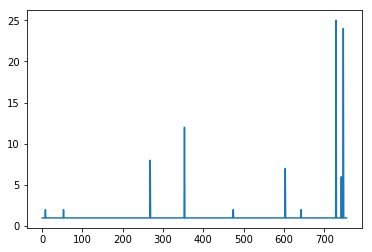

In [120]:
plt.plot(dfMissingByPlayer.missing_rows_count)

In [121]:
# It looks like 10-12 players has missing value more than 1 however rest all have missing value just 1

In [123]:
# Lets find count of those who has missing values more than 1
dfMissingByPlayer[dfMissingByPlayer.missing_rows_count > 1]

,player_api_id,missing_rows_count
8,11285,2
53,23019,2
268,32968,8
353,37254,12
474,39136,2
603,42116,7
642,46256,2
729,110189,25
742,163838,6
747,193866,24


In [124]:
# Total 10 players who has missing values, lets drop them at this time but we will look at them later on how to imputate them

In [129]:
# Lets find out null values after dropping or removing null values for overall_rating
dfPlayerAttributes[dfPlayerAttributes.overall_rating.notnull()].isna().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating            0
potential                 0
preferred_foot            0
attacking_work_rate    2394
defensive_work_rate       0
crossing                  0
finishing                 0
heading_accuracy          0
short_passing             0
volleys                1877
dribbling                 0
curve                  1877
free_kick_accuracy        0
long_passing              0
ball_control              0
acceleration              0
sprint_speed              0
agility                1877
reactions                 0
balance                1877
shot_power                0
jumping                1877
stamina                   0
strength                  0
long_shots                0
aggression                0
interceptions             0
positioning               0
vision                 1877
penalties                 0
marking                   0
standing_tackle     

In [131]:
# Still there are 2394 rows with missing attacking_work_rate values. Lets drop them, we will find reason for them later

In [132]:
dfPlayerAttributes[dfPlayerAttributes.attacking_work_rate.notnull()].isna().sum()

id                       0
player_fifa_api_id       0
player_api_id            0
date                     0
overall_rating           0
potential                0
preferred_foot           0
attacking_work_rate      0
defensive_work_rate      0
crossing                 0
finishing                0
heading_accuracy         0
short_passing            0
volleys                394
dribbling                0
curve                  394
free_kick_accuracy       0
long_passing             0
ball_control             0
acceleration             0
sprint_speed             0
agility                394
reactions                0
balance                394
shot_power               0
jumping                394
stamina                  0
strength                 0
long_shots               0
aggression               0
interceptions            0
positioning              0
vision                 394
penalties                0
marking                  0
standing_tackle          0
sliding_tackle         394
g

In [133]:
#Still dropping by just attacking_work_rate leaves 394 null vlues at few columns. THATS IT, LETS DROP ALL and CONTINUE regression

In [201]:
dfPlayerAttributes = dfPlayerAttributes.dropna()
dfPlayerAttributes.isna().sum()

id                     0
player_fifa_api_id     0
player_api_id          0
date                   0
overall_rating         0
potential              0
preferred_foot         0
attacking_work_rate    0
defensive_work_rate    0
crossing               0
finishing              0
heading_accuracy       0
short_passing          0
volleys                0
dribbling              0
curve                  0
free_kick_accuracy     0
long_passing           0
ball_control           0
acceleration           0
sprint_speed           0
agility                0
reactions              0
balance                0
shot_power             0
jumping                0
stamina                0
strength               0
long_shots             0
aggression             0
interceptions          0
positioning            0
vision                 0
penalties              0
marking                0
standing_tackle        0
sliding_tackle         0
gk_diving              0
gk_handling            0
gk_kicking             0


In [142]:
# No null values

In [143]:
dfPlayerAttributes.shape

(180354, 42)

In [144]:
# Lets drop ID columns and convert date variable into readable date

In [202]:
dfPlayerAttributes.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [227]:
impColumns = ['date', 'overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
              'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
              'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility',
              'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
              'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
              'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']

In [204]:
# Lets convert date with timestamp values into simple dates
dfPlayerAttributes['date'] = pd.to_datetime(dfPlayerAttributes['date'])
dfPlayerAttributes[impColumns].head()

,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2016-02-18,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2015-11-19,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,2015-09-21,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,2015-03-20,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,2007-02-22,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [156]:
# Now lets start visualization and statistics

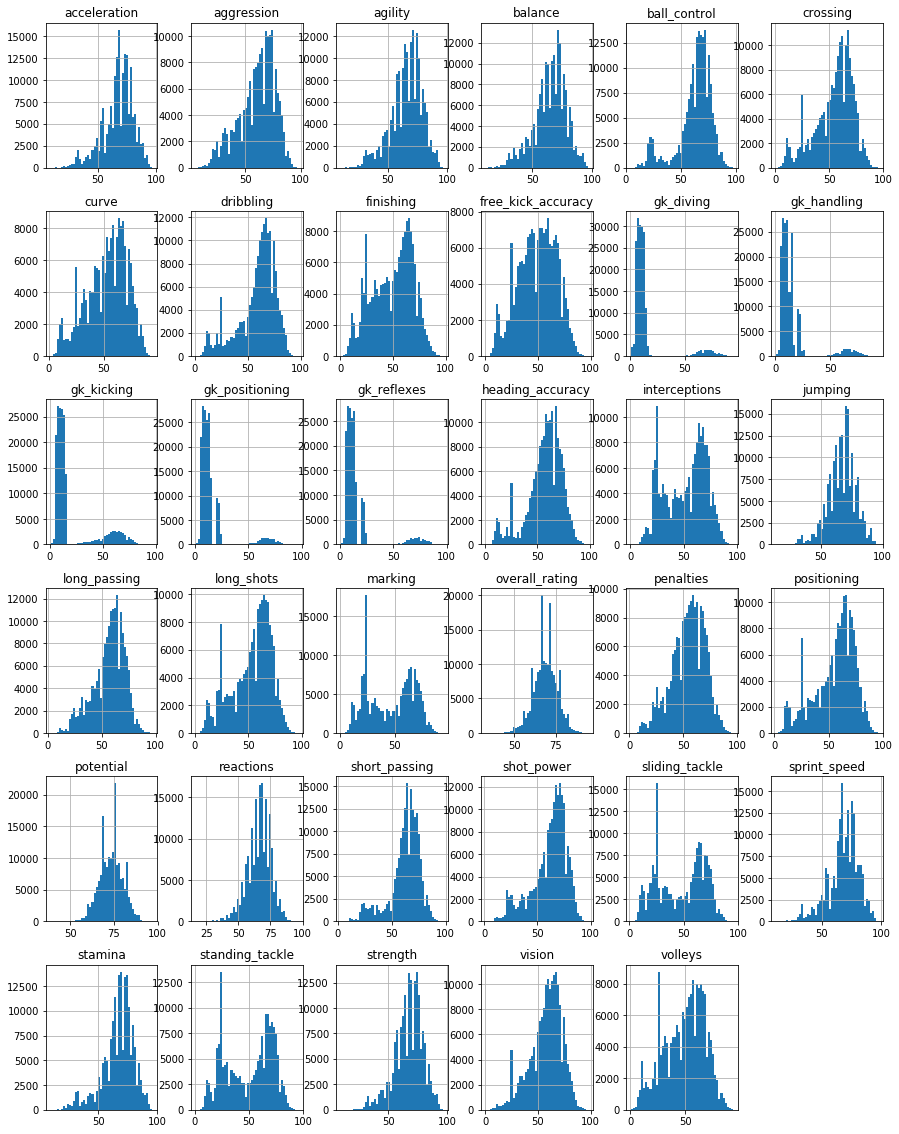

In [157]:
dfPlayerAttributes[impColumns].hist(bins=50, figsize=(15,20))
plt.show()

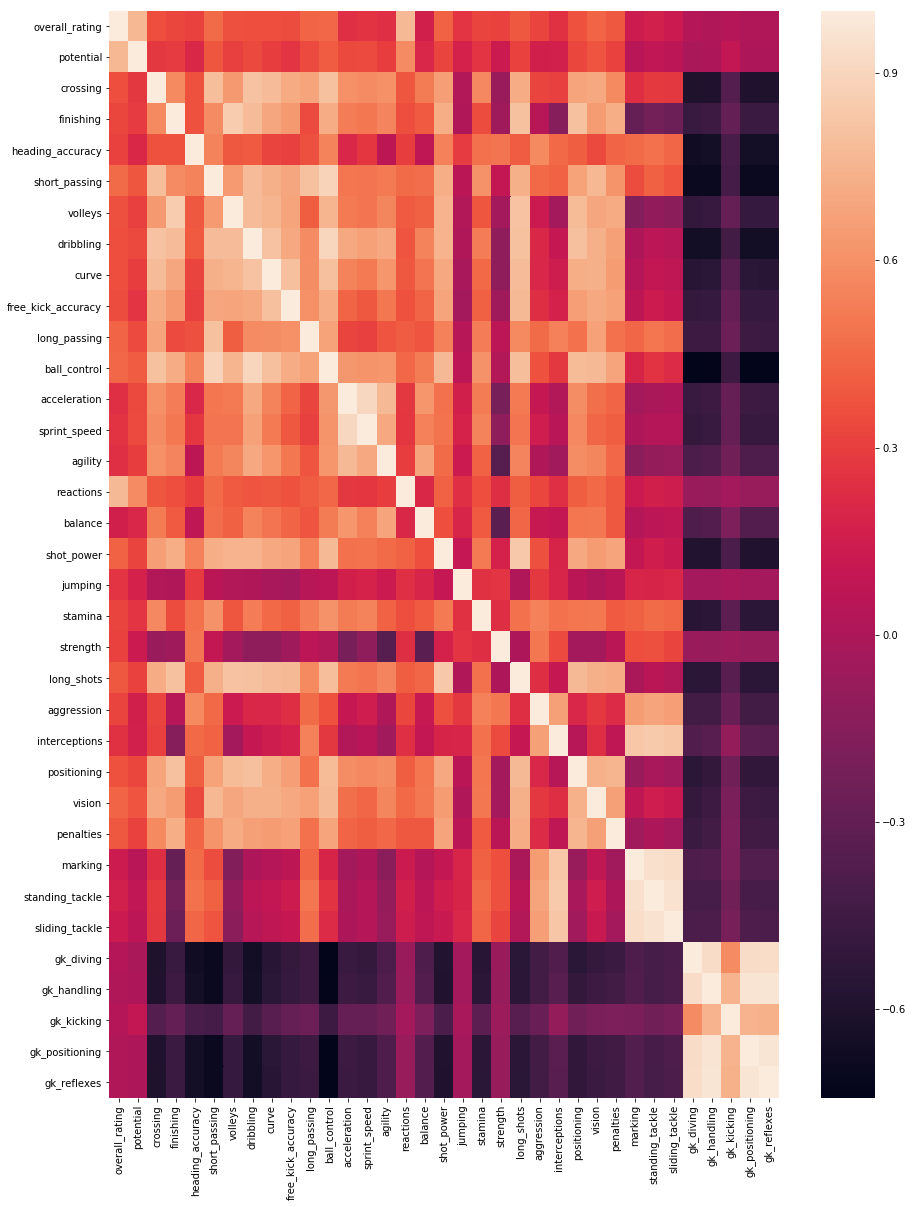

In [161]:
#fitsize
# Use pd.to_datetime to convert 
fig, ax = plt.subplots(figsize=(15,20))
sns.heatmap(dfPlayerAttributes[impColumns].corr())

In [ ]:
#Lets drop potential because its similar to overall_Rating and it has highest correlation with dependant variable but it is same as dependant variable

In [228]:
impColumns.remove('potential')

In [229]:
impColumns.remove('overall_rating')

In [207]:
# Lets convert categorical features into numerical using dummies or factorize because skilearn doesnt allow to train model

In [208]:
dfPlayerAttributes[impColumns].describe(include='object')

,preferred_foot,attacking_work_rate,defensive_work_rate
count,180354,180354,180354
unique,2,8,18
top,right,medium,medium
freq,136247,125070,130846


In [180]:
labels, unique = pd.factorize(dfPlayerAttributes.preferred_foot)
unique

Index(['right', 'left'], dtype='object')

In [181]:
labels, unique = pd.factorize(dfPlayerAttributes.attacking_work_rate)
unique

Index(['medium', 'high', 'low', 'None', 'le', 'norm', 'stoc', 'y'], dtype='object')

In [182]:
labels, unique = pd.factorize(dfPlayerAttributes.defensive_work_rate)
unique

Index(['medium', 'high', 'low', '5', 'ean', 'o', '1', 'ormal', '7', '2', '8',
       '4', 'tocky', '0', '3', '6', '9', 'es'],
      dtype='object')

In [183]:
# From above, it looks like data in these categorical variables are not ordinal and some looks junk data

In [184]:
# STILL CONTINUE WITH DUMMIES FOR ALL AND BUILD FIRST MODELTO GET THE INITIAL ACCURACY AND PREDICTION

In [209]:
dummyDefensive = pd.get_dummies(dfPlayerAttributes.defensive_work_rate, prefix='defensive', drop_first=True)

In [210]:
dummyAttacking = pd.get_dummies(dfPlayerAttributes.attacking_work_rate, prefix='attacking', drop_first=True)

In [211]:
dummyPrefFoot = pd.get_dummies(dfPlayerAttributes.preferred_foot, prefix='prefFoot', drop_first=True)

In [212]:
dfPlayerAttributes = dfPlayerAttributes.join(dummyDefensive)

In [213]:
dfPlayerAttributes = dfPlayerAttributes.join(dummyAttacking)
dfPlayerAttributes = dfPlayerAttributes.join(dummyPrefFoot)

In [231]:
impColumns.extend(dummyDefensive.columns.values)
impColumns.extend(dummyAttacking.columns.values)
impColumns.extend(dummyPrefFoot.columns.values)

In [232]:
impColumns.remove('date')
impColumns.remove('defensive_work_rate')
impColumns.remove('attacking_work_rate')
impColumns.remove('preferred_foot')

In [234]:
x_train, x_test, y_train, y_test = train_test_split(dfPlayerAttributes[impColumns], dfPlayerAttributes['overall_rating'], test_size=0.3
                                                   ,random_state=12345)

In [235]:
x_train.shape

(126247, 58)

In [236]:
y_train.shape

(126247,)

In [237]:
lrModel = LinearRegression()

In [238]:
lrModel.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [239]:
lrModel.score(x_train, y_train)

0.7860557292656732

In [241]:
lrModel.score(x_test, y_test)

0.7888279632214654

In [242]:
y_predicted = lrModel.predict(x_test)

In [258]:
y_test.shape

(54107,)

In [264]:
print('Error in prediction is ', ((y_predicted-y_test)**2).sum()/y_test.shape[0])

Error in prediction is  10.540002311351333


<h3>
    After Data Cleaning - Fit model again
</h3>

In [138]:
# Lets convert date with timestamp values into simple dates
dfPlayerAttributes['new_date'] = pd.to_datetime(dfPlayerAttributes['date'])
dfPlayerAttributes.drop(columns='date', inplace=True)
dfPlayerAttributes.head()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,new_date
0,1,218353,505942,67.0,71.0,right,medium,medium,49.0,44.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,2016-02-18
1,2,218353,505942,67.0,71.0,right,medium,medium,49.0,44.0,...,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,2015-11-19
2,3,218353,505942,62.0,66.0,right,medium,medium,49.0,44.0,...,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,2015-09-21
3,4,218353,505942,61.0,65.0,right,medium,medium,48.0,43.0,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,2015-03-20
4,5,218353,505942,61.0,65.0,right,medium,medium,48.0,43.0,...,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,2007-02-22


In [139]:
dfPlayerAttributes['Year'] = dfPlayerAttributes['new_date'].dt.year
dfPlayerAttributes['Month'] = dfPlayerAttributes['new_date'].dt.month
dfPlayerAttributes.drop(columns='new_date', inplace=True)
dfPlayerAttributes.head()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,Year,Month
0,1,218353,505942,67.0,71.0,right,medium,medium,49.0,44.0,...,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,2016,2
1,2,218353,505942,67.0,71.0,right,medium,medium,49.0,44.0,...,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,2015,11
2,3,218353,505942,62.0,66.0,right,medium,medium,49.0,44.0,...,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,2015,9
3,4,218353,505942,61.0,65.0,right,medium,medium,48.0,43.0,...,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,2015,3
4,5,218353,505942,61.0,65.0,right,medium,medium,48.0,43.0,...,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,2007,2


In [140]:
catObjects = dfPlayerAttributes.dtypes =='object'
catColumns = catObjects[catObjects.values].index.values
catColumns

array(['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'],
      dtype=object)

preferred_foot
****************************************
right    138409
left      44733
Name: preferred_foot, dtype: int64
attacking_work_rate
****************************************
medium    125070
high       42823
low         8569
None        3639
norm         348
y            106
le           104
stoc          89
Name: attacking_work_rate, dtype: int64
defensive_work_rate
****************************************
medium    130846
high       27041
low        18432
_0          2394
o           1550
1            441
ormal        348
2            342
3            258
5            234
7            217
0            197
6            197
9            152
4            116
es           106
ean          104
tocky         89
8             78
Name: defensive_work_rate, dtype: int64


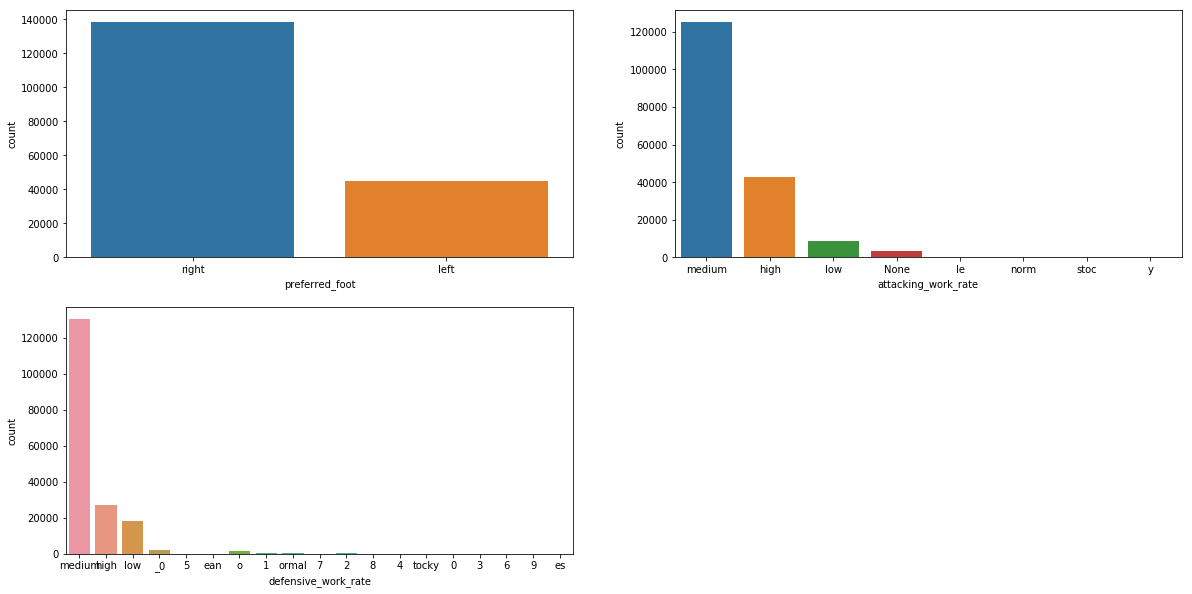

In [141]:
plt.figure(figsize=(20,10))

for i in range(0,len(catColumns)):
        plt.subplot(2,2,i+1)
        sns.countplot(x=catColumns[i], data=dfPlayerAttributes)

for i in range(0,len(catColumns)):
        print(catColumns[i])
        print('*'*40)
        print(dfPlayerAttributes[catColumns[i]].value_counts())
        print('='*40)

In [142]:
# Although we should drop lowest values in a categorical variable but only after statistical tests for mean and variance
# But we will do that later and timebeing we will drop them

In [143]:
dfPlayerAttributes.loc[dfPlayerAttributes.defensive_work_rate.isin(['_0', 'o']) == True, 'defensive_work_rate'] = 'low'

In [144]:
dfPlayerAttributes.defensive_work_rate.unique()

array(['medium', 'high', 'low', None, '5', 'ean', '1', 'ormal', '7', '2',
       '8', '4', 'tocky', '0', '3', '6', '9', 'es'], dtype=object)

In [145]:
dfPlayerAttributes = dfPlayerAttributes[dfPlayerAttributes.defensive_work_rate.isin(['medium', 'high', 'low']) == True]

In [146]:
dfPlayerAttributes = dfPlayerAttributes[dfPlayerAttributes.attacking_work_rate.isin(['medium', 'high', 'low']) == True]

In [147]:
dfPlayerAttributes.defensive_work_rate.unique()

array(['medium', 'high', 'low'], dtype=object)

In [148]:
dfPlayerAttributes.attacking_work_rate.unique()

array(['medium', 'high', 'low'], dtype=object)

In [149]:
replaced, unique = pd.factorize(dfPlayerAttributes.attacking_work_rate)
replaced

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [150]:
dfPlayerAttributes['New_Attacking_WR'] = replaced

In [151]:
replaced, unique = pd.factorize(dfPlayerAttributes.defensive_work_rate)
replaced

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

In [152]:
dfPlayerAttributes['New_Defensive_WR'] = replaced

In [153]:
dfPlayerAttributes.drop(columns=['attacking_work_rate', 'defensive_work_rate'], inplace=True)

In [154]:
dfPlayerAttributes.head()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,preferred_foot,crossing,finishing,heading_accuracy,short_passing,...,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,Year,Month,New_Attacking_WR,New_Defensive_WR
0,1,218353,505942,67.0,71.0,right,49.0,44.0,71.0,61.0,...,69.0,6.0,11.0,10.0,8.0,8.0,2016,2,0,0
1,2,218353,505942,67.0,71.0,right,49.0,44.0,71.0,61.0,...,69.0,6.0,11.0,10.0,8.0,8.0,2015,11,0,0
2,3,218353,505942,62.0,66.0,right,49.0,44.0,71.0,61.0,...,69.0,6.0,11.0,10.0,8.0,8.0,2015,9,0,0
3,4,218353,505942,61.0,65.0,right,48.0,43.0,70.0,60.0,...,66.0,5.0,10.0,9.0,7.0,7.0,2015,3,0,0
4,5,218353,505942,61.0,65.0,right,48.0,43.0,70.0,60.0,...,66.0,5.0,10.0,9.0,7.0,7.0,2007,2,0,0


In [155]:
dfPlayerAttributes.isna().any()

id                    False
player_fifa_api_id    False
player_api_id         False
overall_rating        False
potential             False
preferred_foot        False
crossing              False
finishing             False
heading_accuracy      False
short_passing         False
volleys               False
dribbling             False
curve                 False
free_kick_accuracy    False
long_passing          False
ball_control          False
acceleration          False
sprint_speed          False
agility               False
reactions             False
balance               False
shot_power            False
jumping               False
stamina               False
strength              False
long_shots            False
aggression            False
interceptions         False
positioning           False
vision                False
penalties             False
marking               False
standing_tackle       False
sliding_tackle        False
gk_diving             False
gk_handling         

In [156]:
# This is a great finding, all null values were there only for those who had attacking or defensive different than 'low' 'medium' 'high'
# Thats why they got dropped

In [157]:
dfPlayerAttributes.describe(include='object')

,preferred_foot
count,176161
unique,2
top,right
freq,133102


In [158]:
dfPrefFoot = pd.get_dummies(dfPlayerAttributes.preferred_foot, prefix='prefferedFoot')
dfPrefFoot.shape

(176161, 2)

In [159]:
dfPlayerAttributes.shape

(176161, 43)

In [160]:
dfPlayerAttributes = dfPlayerAttributes.join(dfPrefFoot)

In [161]:
dfPlayerAttributes.drop(columns='preferred_foot', inplace=True)

In [162]:
impColumns = dfPlayerAttributes.columns.values.tolist()
impColumns.remove('id')
impColumns.remove('player_fifa_api_id')
impColumns.remove('player_api_id')
impColumns.remove('potential')
impColumns.remove('overall_rating')

<h3>
Apply model
</h3>

In [45]:
x_train, x_test, y_train, y_test = train_test_split(dfPlayerAttributes[impColumns], dfPlayerAttributes['overall_rating'], test_size=0.3, random_state=12345)
x_train.shape

(123312, 39)

In [46]:
lm = LinearRegression()

In [47]:
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [48]:
lm.coef_

array([-0.00942666,  0.01257514,  0.10163556,  0.06888652,  0.00098433,
       -0.01768174,  0.00809114,  0.01093412,  0.01921697,  0.22703986,
        0.04112957,  0.04877553, -0.01623896,  0.27591946,  0.00517547,
        0.02407009,  0.00909766, -0.01818106,  0.05759357, -0.0248486 ,
        0.01008415,  0.0224126 , -0.02335901,  0.01695873,  0.01911234,
        0.03083865,  0.01127612, -0.02873695,  0.18701363,  0.05594591,
       -0.0108765 ,  0.07500122,  0.04699705,  0.21453874,  0.02084688,
        0.44793977,  0.32838953,  0.03675507, -0.03675507])

In [49]:
lm.intercept_

-424.7880629557719

In [50]:
lm.score(x_train, y_train)

0.7913209180100091

In [51]:
y_predicted = lm.predict(x_test)

In [53]:
lm.score(x_test, y_test)

0.7886859855748739

In [57]:
math.sqrt(np.mean((y_predicted - y_test)**2))

3.2063835394889395

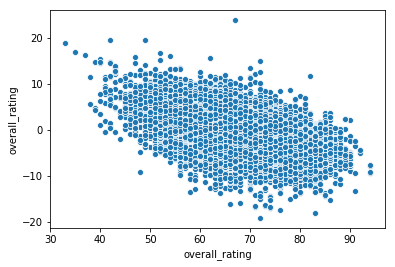

In [58]:
sns.scatterplot(y_test, (y_predicted - y_test))

In [59]:
# It looks like there is some pattern in variance and predicted values
# Relationship looks slightly negative

<h3>
Lets test for importance of variables in model
</h3>

In [64]:
dumm = pd.read_sql_query('select * from Player_Attributes', conn)

In [66]:
dumm.to_csv('SoccerData.csv')

In [61]:
model = sm.OLS(y_train, x_train).fit()

In [63]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                 1.230e+04
Date:                Wed, 20 Mar 2019   Prob (F-statistic):               0.00
Time:                        00:28:28   Log-Likelihood:            -3.1909e+05
No. Observations:              123312   AIC:                         6.383e+05
Df Residuals:                  123273   BIC:                         6.386e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
crossing               -0.0094      0.001     -8.075      0.000      -0.012      -0.007
finishing               0.0126      0.001      9.714      0.000       0.010       0.015
heading_accuracy        0.1016      0.001     89.756      0.000       0.099       0.104
short_passing           0.0689      0.002     35.381      0.000       0.065       0.073
volleys                 0.0010      0.001      0.852      0.394      -0.001       0.003
dribbling              -0.0177      0.002    -10.775      0.000      -0.021      -0.014
curve                   0.0081      0.001      7.190      0.000       0.006       0.010
free_kick_accuracy      0.0109      0.001     10.934      0.000       0.009       0.013
long_passing            0.0192      0.001     14.490      0.000       0.017       0.022
ball_control            0.2270      0.002    104.632      0.000       0.223       0.231
acceleration            0.0411      0.002     21.404      0.000       0.037       0.045
sprint_speed            0.0488      0.002     26.884      0.000       0.045       0.052
agility                -0.0162      0.001    -11.438      0.000      -0.019      -0.013
reactions               0.2759      0.001    186.852      0.000       0.273       0.279
balance                 0.0052      0.001      4.722      0.000       0.003       0.007
shot_power              0.0241      0.001     19.515      0.000       0.022       0.026
jumping                 0.0091      0.001      8.962      0.000       0.007       0.011
stamina                -0.0182      0.001    -16.050      0.000      -0.020      -0.016
strength                0.0576      0.001     48.742      0.000       0.055       0.060
long_shots             -0.0248      0.001    -19.316      0.000      -0.027      -0.022
aggression              0.0101      0.001     10.518      0.000       0.008       0.012
interceptions           0.0224      0.001     21.534      0.000       0.020       0.024
positioning            -0.0234      0.001    -20.972      0.000      -0.026      -0.021
vision                  0.0170      0.001     13.657      0.000       0.015       0.019
penalties               0.0191      0.001     18.133      0.000       0.017       0.021
marking                 0.0308      0.002     19.596      0.000       0.028       0.034
standing_tackle         0.0113      0.002      6.197      0.000       0.008       0.015
sliding_tackle         -0.0287      0.002    -18.547      0.000      -0.032      -0.026
gk_diving               0.1870      0.002     90.487      0.000       0.183       0.191
gk_handling             0.0559      0.003     20.926      0.000       0.051       0.061
gk_kicking             -0.0109      0.001    -11.160      0.000      -0.013      -0.009
gk_positioning          0.0750      0.003     28.189      0.000       0.070       0.080
gk_

<h3>
There is not a major improvement in R score. Lets split few variables into Categorical ordinal and try again
</h3>

In [87]:
try:
    for i in dfPlayerAttributes.columns:    
        if(i.index("k_") > 0):
            print(i)
except:
    print('faield')

faield


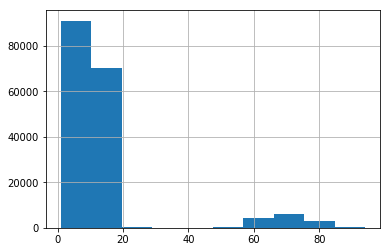

In [131]:
dfPlayerAttributes.gk_diving.hist()

In [163]:
dfPlayerAttributes.loc[dfPlayerAttributes.gk_diving <= 40, 'gk_diving'] = 0
dfPlayerAttributes.loc[dfPlayerAttributes.gk_diving > 40, 'gk_diving'] = 1

In [164]:
dfPlayerAttributes.gk_diving.unique()

array([0., 1.])

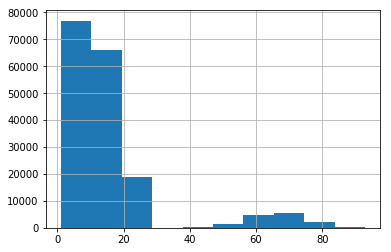

In [165]:
dfPlayerAttributes.gk_handling.hist()

In [166]:
dfPlayerAttributes.loc[dfPlayerAttributes.gk_handling <= 35, 'gk_handling'] = 0
dfPlayerAttributes.loc[dfPlayerAttributes.gk_handling > 35, 'gk_handling'] = 1

In [167]:
dfPlayerAttributes.gk_handling.unique()

array([0., 1.])

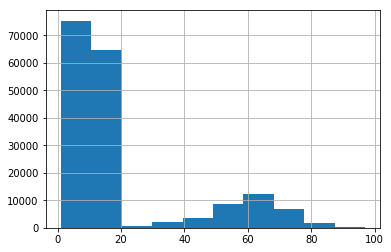

In [168]:
dfPlayerAttributes.gk_kicking.hist()

In [169]:
dfPlayerAttributes.loc[dfPlayerAttributes.gk_kicking <= 25, 'gk_kicking'] = 0
dfPlayerAttributes.loc[dfPlayerAttributes.gk_kicking > 25, 'gk_kicking'] = 1

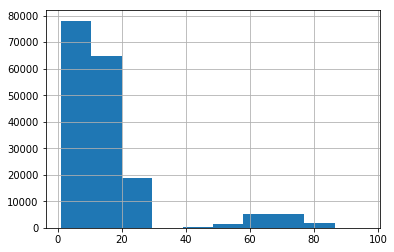

In [170]:
dfPlayerAttributes.gk_positioning.hist()

In [171]:
dfPlayerAttributes.loc[dfPlayerAttributes.gk_positioning <= 35, 'gk_positioning'] = 0
dfPlayerAttributes.loc[dfPlayerAttributes.gk_positioning > 35, 'gk_positioning'] = 1

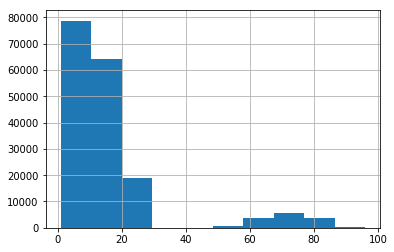

In [172]:
dfPlayerAttributes.gk_reflexes.hist()

In [173]:
dfPlayerAttributes.loc[dfPlayerAttributes.gk_reflexes <= 40, 'gk_reflexes'] = 0
dfPlayerAttributes.loc[dfPlayerAttributes.gk_reflexes > 40, 'gk_reflexes'] = 1

In [174]:
x_train, x_test, y_train, y_test = train_test_split(dfPlayerAttributes[impColumns], dfPlayerAttributes['overall_rating'], test_size=0.3, random_state=12345)
x_train.shape

(123312, 39)

<h3>
Lets apply Model now - stats model
</h3>

In [185]:
model = sm.OLS(y_train, x_train).fit()

In [186]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                 1.124e+04
Date:                Wed, 20 Mar 2019   Prob (F-statistic):               0.00
Time:                        05:56:46   Log-Likelihood:            -3.2345e+05
No. Observations:              123312   AIC:                         6.470e+05
Df Residuals:                  123273   BIC:                         6.474e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
crossing               -0.0091      0.001     -7.522      0.000      -0.011      -0.007
finishing               0.0133      0.001      9.947      0.000       0.011       0.016
heading_accuracy        0.0954      0.001     81.099      0.000       0.093       0.098
short_passing           0.0657      0.002     32.624      0.000       0.062       0.070
volleys                -0.0002      0.001     -0.138      0.890      -0.003       0.002
dribbling              -0.0216      0.002    -12.712      0.000      -0.025      -0.018
curve                   0.0071      0.001      6.058      0.000       0.005       0.009
free_kick_accuracy      0.0072      0.001      6.998      0.000       0.005       0.009
long_passing            0.0185      0.001     13.311      0.000       0.016       0.021
ball_control            0.2198      0.002     97.680      0.000       0.215       0.224
acceleration            0.0421      0.002     21.170      0.000       0.038       0.046
sprint_speed            0.0535      0.002     28.430      0.000       0.050       0.057
agility                -0.0153      0.001    -10.396      0.000      -0.018      -0.012
reactions               0.2997      0.002    199.217      0.000       0.297       0.303
balance                 0.0054      0.001      4.714      0.000       0.003       0.008
shot_power              0.0242      0.001     18.969      0.000       0.022       0.027
jumping                 0.0130      0.001     12.418      0.000       0.011       0.015
stamina                -0.0232      0.001    -19.806      0.000      -0.026      -0.021
strength                0.0633      0.001     51.787      0.000       0.061       0.066
long_shots             -0.0272      0.001    -20.420      0.000      -0.030      -0.025
aggression              0.0092      0.001      9.267      0.000       0.007       0.011
interceptions           0.0261      0.001     24.000      0.000       0.024       0.028
positioning            -0.0251      0.001    -21.742      0.000      -0.027      -0.023
vision                  0.0257      0.001     19.948      0.000       0.023       0.028
penalties               0.0256      0.001     23.484      0.000       0.023       0.028
marking                 0.0331      0.002     20.284      0.000       0.030       0.036
standing_tackle         0.0065      0.002      3.425      0.001       0.003       0.010
sliding_tackle         -0.0292      0.002    -18.164      0.000      -0.032      -0.026
gk_diving               9.6554      1.135      8.504      0.000       7.430      11.881
gk_handling             1.3906      1.579      0.880      0.379      -1.705       4.486
gk_kicking              0.3963      0.041      9.623      0.000       0.316       0.477
gk_positioning          6.7344      1.293      5.208      0.000       4.200       9.269
gk_

In [187]:
# Since volleys and gk_handling has higher pvalue so they are redundant and do not provide any info. Lets drop them

In [189]:
impColumns.remove('gk_handling')
impColumns.remove('volleys')

In [190]:
model = sm.OLS(y_train, x_train[impColumns]).fit()

In [191]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                 1.186e+04
Date:                Wed, 20 Mar 2019   Prob (F-statistic):               0.00
Time:                        05:59:35   Log-Likelihood:            -3.2345e+05
No. Observations:              123312   AIC:                         6.470e+05
Df Residuals:                  123275   BIC:                         6.473e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
crossing               -0.0091      0.001     -7.528      0.000      -0.011      -0.007
finishing               0.0133      0.001     10.278      0.000       0.011       0.016
heading_accuracy        0.0954      0.001     81.319      0.000       0.093       0.098
short_passing           0.0657      0.002     32.630      0.000       0.062       0.070
dribbling              -0.0216      0.002    -12.739      0.000      -0.025      -0.018
curve                   0.0070      0.001      6.105      0.000       0.005       0.009
free_kick_accuracy      0.0072      0.001      6.994      0.000       0.005       0.009
long_passing            0.0186      0.001     13.398      0.000       0.016       0.021
ball_control            0.2198      0.002     97.684      0.000       0.215       0.224
acceleration            0.0421      0.002     21.180      0.000       0.038       0.046
sprint_speed            0.0534      0.002     28.431      0.000       0.050       0.057
agility                -0.0153      0.001    -10.405      0.000      -0.018      -0.012
reactions               0.2997      0.002    199.575      0.000       0.297       0.303
balance                 0.0054      0.001      4.715      0.000       0.003       0.008
shot_power              0.0242      0.001     19.046      0.000       0.022       0.027
jumping                 0.0131      0.001     12.421      0.000       0.011       0.015
stamina                -0.0232      0.001    -19.820      0.000      -0.026      -0.021
strength                0.0633      0.001     51.790      0.000       0.061       0.066
long_shots             -0.0272      0.001    -20.649      0.000      -0.030      -0.025
aggression              0.0092      0.001      9.270      0.000       0.007       0.011
interceptions           0.0261      0.001     24.010      0.000       0.024       0.028
positioning            -0.0251      0.001    -21.756      0.000      -0.027      -0.023
vision                  0.0257      0.001     19.982      0.000       0.023       0.028
penalties               0.0256      0.001     23.507      0.000       0.023       0.028
marking                 0.0331      0.002     20.353      0.000       0.030       0.036
standing_tackle         0.0065      0.002      3.425      0.001       0.003       0.010
sliding_tackle         -0.0292      0.002    -18.198      0.000      -0.032      -0.026
gk_diving              10.2292      0.930     11.002      0.000       8.407      12.052
gk_kicking              0.3961      0.041      9.633      0.000       0.316       0.477
gk_positioning          7.3271      1.105      6.631      0.000       5.161       9.493
gk_reflexes             2.3525      1.038      2.266      0.023       0.318       4.387
Year                    0.2060      0.005     40.349      0.000       0.196       0.216
Mon

In [192]:
y_predicted = model.predict(x_test[impColumns])

In [194]:
model.conf_int()

,0,1
crossing,-0.011469,-0.006731
finishing,0.010758,0.015827
heading_accuracy,0.093103,0.097702
short_passing,0.061738,0.069628
dribbling,-0.024950,-0.018296
curve,0.004776,0.009292
free_kick_accuracy,0.005206,0.009260
long_passing,0.015846,0.021277
ball_control,0.215386,0.224206
acceleration,0.038249,0.046050


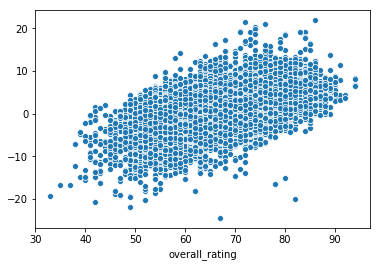

In [195]:
sns.scatterplot(y_test, (y_test - y_predicted))

In [197]:
# STILL No improvement in R square
# It also looks like some variables do not provide any useful info

<h3>
    Statistical Tests - Pending
</h3>

In [213]:
catColumns = ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']
group = 

In [219]:
type(group.agg('overall_rating').mean())

pandas.core.series.Series

In [248]:
dfPlayerAttributes.dropna().shape

(180354, 42)

In [254]:
for i in catColumns:
    print(stats.f_oneway(dfPlayerAttributes.dropna().groupby(by=catColumns).agg('overall_rating').mean()))

F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=nan, pvalue=nan)
F_onewayResult(statistic=nan, pvalue=nan)


In [ ]:
for i in catColumns:
    print(stats.f_oneway(dfPlayerAttributes.dropna().groupby(by=catColumns).agg('overall_rating')))
    #print(stats.ttest_ind(dfPlayerAttributes.dropna().groupby(by=catColumns).agg('overall_rating').mean()))

In [ ]:
dfPlayerAttributes.dropna().groupby(by='preferred_foot')

In [ ]:
?stats.ttest_ind

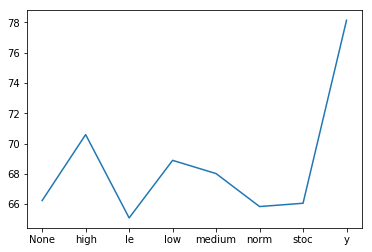

In [232]:
plt.plot(dfPlayerAttributes.dropna().groupby(by='attacking_work_rate').agg('overall_rating').mean())

In [7]:
grpMissingData = dfPlayerAttributes[dfPlayerAttributes.overall_rating.isna()].groupby(by='player_api_id')
dfMissingByPlayer = grpMissingData.agg({'player_api_id': 'count'})
#dfMissingByPlayer.columns = dfMissingByPlayer.columns.droplevel()
dfMissingByPlayer.columns = ['missing_rows_count']
dfMissingByPlayer = dfMissingByPlayer.reset_index()
dfMissingByPlayer.head(5)

,player_api_id,missing_rows_count
0,2907,1
1,3517,1
2,5243,1
3,5247,1
4,6864,1


In [24]:
dfPlayerAttributes.id.isna().any()

False

In [130]:
aggrGroupbyPlayerID_Count = dfPlayerAttributes[dfPlayerAttributes['overall_rating'].isna()==True].groupby(by='player_api_id').agg('count')
aggrGroupbyPlayerID_Count

,id,player_fifa_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
player_api_id,,,,,,,,,,,,,,,,,,,,,
2907,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3517,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5243,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5247,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6864,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7621,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8893,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9086,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11285,2,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
missingIndex = aggrGroupbyPlayerID_Count[aggrGroupbyPlayerID_Count.id > 2].index.values
missingIndex

array([ 32968,  37254,  42116, 110189, 163838, 193866], dtype=int64)

In [132]:
# Drop data where overall_rating for any player missing more than twice
dfPlayerAttributes.drop(dfPlayerAttributes[dfPlayerAttributes.player_api_id.isin(missingIndex)==True].index, inplace=True)

In [31]:
#seriesMissingMorethan2 = dfPlayerAttributes[dfPlayerAttributes['overall_rating'].isna()].groupby(by='player_api_id').agg('count') > 2
#seriesMissingMorethan2.head()

In [32]:
# Now lets replace null values with their own mean values

In [33]:
aggrGroupbyPlayerID = dfPlayerAttributes.groupby(by='player_api_id').agg('mean')

In [34]:
len(aggrGroupbyPlayerID.index.values)

11054

In [43]:
missingColumns = []
for i in dfPlayerAttributes.columns:
    if(dfPlayerAttributes[i].isna().any()):
        missingColumns.append(i)

In [45]:
print(len(missingColumns))
missingColumns

38


['overall_rating',
 'potential',
 'preferred_foot',
 'attacking_work_rate',
 'defensive_work_rate',
 'crossing',
 'finishing',
 'heading_accuracy',
 'short_passing',
 'volleys',
 'dribbling',
 'curve',
 'free_kick_accuracy',
 'long_passing',
 'ball_control',
 'acceleration',
 'sprint_speed',
 'agility',
 'reactions',
 'balance',
 'shot_power',
 'jumping',
 'stamina',
 'strength',
 'long_shots',
 'aggression',
 'interceptions',
 'positioning',
 'vision',
 'penalties',
 'marking',
 'standing_tackle',
 'sliding_tackle',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_positioning',
 'gk_reflexes']

In [47]:
dfPlayerAttributes.loc[2625]

id                                    2626
player_fifa_api_id                  188770
player_api_id                       132844
date                   2013-10-11 00:00:00
overall_rating                          69
potential                               77
preferred_foot                       right
attacking_work_rate                 medium
defensive_work_rate                 medium
crossing                                53
finishing                               68
heading_accuracy                        56
short_passing                           71
volleys                                 62
dribbling                               72
curve                                   50
free_kick_accuracy                      61
long_passing                            52
ball_control                            70
acceleration                            73
sprint_speed                            72
agility                                 73
reactions                               68
balance    

In [49]:
aggrGroupbyPlayerID.loc[2625]

id                    139850.500000
player_fifa_api_id    148544.000000
overall_rating            60.142857
potential                 61.142857
crossing                  50.142857
finishing                 47.285714
heading_accuracy          46.285714
short_passing             56.500000
volleys                   38.000000
dribbling                 54.142857
curve                     50.000000
free_kick_accuracy        49.928571
long_passing              65.571429
ball_control              59.142857
acceleration              66.857143
sprint_speed              63.285714
agility                   66.428571
reactions                 49.714286
balance                   66.214286
shot_power                66.714286
jumping                   58.714286
stamina                   77.285714
strength                  55.785714
long_shots                56.857143
aggression                71.285714
interceptions             62.071429
positioning               50.357143
vision                    55

In [ ]:
dfPlayerAttributes.isna().any()

In [56]:
missingColumns.remove('preferred_foot')

In [58]:
missingColumns.remove('attacking_work_rate')

In [60]:
missingColumns.remove('defensive_work_rate')

In [99]:
dfPlayerAttributes.set_index('player_api_id', inplace=True)

In [113]:
for i in missingColumns:
    dfPlayerAttributes[i].fillna(value=aggrGroupbyPlayerID[i], inplace=True)

In [121]:
# How come still some null values in the dataframe after filling null values
dfPlayerAttributes.isna().any()

id                     False
player_fifa_api_id     False
date                   False
overall_rating         False
potential              False
preferred_foot          True
attacking_work_rate     True
defensive_work_rate     True
crossing               False
finishing              False
heading_accuracy       False
short_passing          False
volleys                 True
dribbling              False
curve                   True
free_kick_accuracy     False
long_passing           False
ball_control           False
acceleration           False
sprint_speed           False
agility                 True
reactions              False
balance                 True
shot_power             False
jumping                 True
stamina                False
strength               False
long_shots             False
aggression             False
interceptions          False
positioning            False
vision                  True
penalties              False
marking                False
standing_tackl

In [122]:
# Because there are some players who has all the nulls values and thats why aggregated values were also null and null never replaced
aggrGroupbyPlayerID.curve

player_api_id
2625      50.000000
2752      30.428571
2768      51.761905
2770      79.800000
2790      67.000000
2796      18.533333
2802      80.090909
2805      56.750000
2857      65.687500
2862      70.617647
2907      62.800000
2973      58.444444
2977      30.000000
2983      54.100000
2984      25.000000
3140      63.000000
3204      75.137931
3263            NaN
3264      46.000000
3316      57.615385
3329      33.600000
3377      63.393939
3441      46.285714
3512      65.076923
3517      66.142857
3520      74.240000
4747            NaN
4863      33.000000
4902      70.272727
4939      34.227273
            ...    
701154    49.333333
703659    32.000000
704523    62.000000
705484    25.000000
706985    45.000000
710807    31.000000
715642    35.000000
716998    54.000000
717248    49.000000
717270    52.000000
717557    63.000000
719413    62.000000
720738    38.000000
721133    69.076923
722766    53.722222
723037    33.000000
725718    30.000000
726956    34.000000
728125

In [125]:
# Now lets replace values in preferred foot and attacking or defensive work rate

<b>
    Lets try to improve score by replacing null values - pending
</b>

In [123]:
# Enough is enough, Lets drop null values
dfPlayerAttributes = dfPlayerAttributes.dropna()

In [124]:
dfPlayerAttributes.isna().any()

id                     False
player_fifa_api_id     False
date                   False
overall_rating         False
potential              False
preferred_foot         False
attacking_work_rate    False
defensive_work_rate    False
crossing               False
finishing              False
heading_accuracy       False
short_passing          False
volleys                False
dribbling              False
curve                  False
free_kick_accuracy     False
long_passing           False
ball_control           False
acceleration           False
sprint_speed           False
agility                False
reactions              False
balance                False
shot_power             False
jumping                False
stamina                False
strength               False
long_shots             False
aggression             False
interceptions          False
positioning            False
vision                 False
penalties              False
marking                False
standing_tackl

In [86]:
tmp[tmp.isna()].shape

(183706, 35)

In [112]:
# Lets set index by player ID so that we can compare by player ID in aggrGrouop which has missing values
#dfPlayerAttributes.set_index('player_api_id', inplace=True)

In [54]:
#for i in aggrGroupbyPlayerID:
#    dfPlayerAttributes.loc[i].fillna(value=aggrGroupbyPlayerID.loc[i])

In [55]:
#for i in aggrGroupbyPlayerID.index.values:
#    print(dfPlayerAttributes.set_index('player_api_id').loc[i])

In [ ]:
aggrGroupbyPlayerID.overall_rating[]

In [ ]:
for i in missingColumns:
    print(aggrGroupbyPlayerID)

In [59]:
mostMissingPlayerIDs = dfMissingByPlayer[dfMissingByPlayer.missing_rows_count > 2].player_api_id.tolist()
mostMissingPlayerIDs

[32968, 37254, 42116, 110189, 163838, 193866]

In [70]:
dfPlayerAttributes.drop(dfPlayerAttributes[dfPlayerAttributes.player_api_id.isin(mostMissingPlayerIDs)].index, inplace=True)
dfPlayerAttributes.shape

(183706, 42)

In [71]:
# More than 2 missing values for same player ID is dropped

In [74]:
dfPlayerAttributes[dfPlayerAttributes.isnull().any(axis=1)]

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
373,374,156626,46447,2010-08-30 00:00:00,64.0,71.0,right,None,_0,41.0,...,61.0,39.0,62.0,61.0,57.0,15.0,14.0,13.0,10.0,12.0
374,375,156626,46447,2010-02-22 00:00:00,64.0,71.0,right,None,_0,41.0,...,61.0,58.0,62.0,61.0,57.0,6.0,20.0,45.0,20.0,20.0
375,376,156626,46447,2008-08-30 00:00:00,66.0,71.0,right,None,_0,41.0,...,61.0,58.0,67.0,61.0,57.0,6.0,20.0,45.0,20.0,20.0
376,377,156626,46447,2007-08-30 00:00:00,68.0,75.0,right,None,_0,41.0,...,61.0,58.0,69.0,64.0,57.0,6.0,20.0,45.0,20.0,20.0
377,378,156626,46447,2007-02-22 00:00:00,66.0,65.0,right,None,_0,41.0,...,61.0,55.0,66.0,63.0,57.0,6.0,9.0,45.0,13.0,10.0
392,393,202425,245653,2011-02-22 00:00:00,64.0,69.0,left,None,_0,47.0,...,52.0,42.0,64.0,65.0,62.0,11.0,5.0,15.0,10.0,10.0
393,394,202425,245653,2007-02-22 00:00:00,64.0,69.0,left,None,_0,47.0,...,52.0,42.0,64.0,65.0,62.0,11.0,5.0,15.0,10.0,10.0
446,447,52782,38423,2010-02-22 00:00:00,68.0,70.0,right,None,_0,60.0,...,NaN,47.0,52.0,50.0,NaN,7.0,20.0,62.0,20.0,20.0
447,448,52782,38423,2009-08-30 00:00:00,68.0,70.0,right,None,_0,60.0,...,NaN,47.0,52.0,50.0,NaN,7.0,20.0,62.0,20.0,20.0
448,449,52782,38423,2008-08-30 00:00:00,68.0,69.0,right,None,_0,60.0,...,NaN,47.0,52.0,50.0,NaN,7.0,20.0,62.0,20.0,20.0


In [ ]:
# Use simple impute of sklearn to experiment

In [43]:
dfPlayerAttributes[dfPlayerAttributes.isnull().any(axis=1)]

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
373,374,156626,46447,2010-08-30 00:00:00,64.0,71.0,right,None,_0,41.0,...,61.0,39.0,62.0,61.0,57.0,15.0,14.0,13.0,10.0,12.0
374,375,156626,46447,2010-02-22 00:00:00,64.0,71.0,right,None,_0,41.0,...,61.0,58.0,62.0,61.0,57.0,6.0,20.0,45.0,20.0,20.0
375,376,156626,46447,2008-08-30 00:00:00,66.0,71.0,right,None,_0,41.0,...,61.0,58.0,67.0,61.0,57.0,6.0,20.0,45.0,20.0,20.0
376,377,156626,46447,2007-08-30 00:00:00,68.0,75.0,right,None,_0,41.0,...,61.0,58.0,69.0,64.0,57.0,6.0,20.0,45.0,20.0,20.0
377,378,156626,46447,2007-02-22 00:00:00,66.0,65.0,right,None,_0,41.0,...,61.0,55.0,66.0,63.0,57.0,6.0,9.0,45.0,13.0,10.0
392,393,202425,245653,2011-02-22 00:00:00,64.0,69.0,left,None,_0,47.0,...,52.0,42.0,64.0,65.0,62.0,11.0,5.0,15.0,10.0,10.0
393,394,202425,245653,2007-02-22 00:00:00,64.0,69.0,left,None,_0,47.0,...,52.0,42.0,64.0,65.0,62.0,11.0,5.0,15.0,10.0,10.0
446,447,52782,38423,2010-02-22 00:00:00,68.0,70.0,right,None,_0,60.0,...,NaN,47.0,52.0,50.0,NaN,7.0,20.0,62.0,20.0,20.0
447,448,52782,38423,2009-08-30 00:00:00,68.0,70.0,right,None,_0,60.0,...,NaN,47.0,52.0,50.0,NaN,7.0,20.0,62.0,20.0,20.0
448,449,52782,38423,2008-08-30 00:00:00,68.0,69.0,right,None,_0,60.0,...,NaN,47.0,52.0,50.0,NaN,7.0,20.0,62.0,20.0,20.0
